__собираем статистики по объявлениям о продаже домов__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 09 июл 2024 11:06:20 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_house.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

32964

title  \
1876   дом, 140 м², 4 сот., садоводство   
7265       дом, 68,8 м², 3.04 сот., ижс   
15856     дом, 1 148,9 м², 10 сот., ижс   

                                                   address  latitude  \
1876   севастополь,р-н балаклавский,улица дениса ракицкого     44.52   
7265          севастополь,р-н ленинский,улица лагерная,16а     44.59   
15856               республика крым,судак,улица лучистая,9     44.85   

       longitude  priceM          dt  
1876       33.54   10.60  2024-06-17  
7265       33.53    8.80  2024-06-10  
15856      34.99  120.00  2024-06-13

---

In [4]:
# df_ = pd.read_pickle('data/2023/data_house.pkl').rename(columns={'adr':'address'})
# df_['dt'] = df_['ts'].dt.date
# display( len(df_) )
# display( df_.sample(3)[cols] )

In [5]:
# df_ = (
#         df_
#         .dropna(subset=['dt','url'])
#         .drop_duplicates(['dt','url'])
#         .drop(columns=['adr_orig','obj_name','avito_page'])
#     )
# display( len(df_) )
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# display( df_.sample(3)[cols] )

In [6]:
# # history_date = df_['dt'].max()
# history_date = pd.to_datetime('2023-01-10').date()
# display(history_date)

In [7]:
# df = pd.concat([df,df_]).reset_index(drop=True)
# display( len(df) )
# del df_

---

In [8]:
df['month'] = df['ts'].dt.to_period('M')
df['week'] = df['ts'].dt.to_period('W')

---

In [9]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

32964

32964

In [10]:
display(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_part) & (house_area>40.) & (priceM<15.)')
display(len(df))
df = df.query('priceM>1.') # выкидываем предожения с аномально низкой ценой
display(len(df))

32964

24188

24152

In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
13165   дом, 41,6 м², 2.9 сот., ижс   
27154  дом 104 м² на участке 5 сот.   
7325          дом, 120 м², 4.5 сот.   

                                                               address  \
13165                    севастополь,р-н ленинский,переулок матросский   
27154                                 севастополь,тсн верхняя учкуевка   
7325   севастополь,р-н балаклавский,теремок садоводческое товарищество   

       latitude  longitude  priceM          dt  
13165     44.61      33.51    6.10  2024-06-14  
27154     44.65      33.55    7.50  2024-06-14  
7325      44.51      33.51    9.15  2024-06-10

---

In [12]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
print( dt_min, ' : ',dt_max )
# display( dt_min,history_date,dt_max )

2024-06-07  :  2024-07-08


In [13]:
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

In [14]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [15]:
# display( len(gdf_history) )
# display( len(gdf) )

---

In [16]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [17]:
# gdf['place'].unique()

# общая статистика

In [18]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [19]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [20]:
# gdf[ gdf['address'].str.match(r'.*ялта.*') ]
# gdf[ gdf['address'].str.match(r'.*окуневка.*') ]
# gdf[ gdf['address'].str.match(r'.*заветное.*') ]

In [21]:
gdf.query('place=="bahchisaray"')[['title','address','priceM','geometry']].explore()

In [22]:
gdf.query('place=="sudak"')[['title','address','priceM','geometry']].explore()

In [23]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = (
        #gdf.groupby(['place','house_size_category','month'],observed=True)
        gdf.groupby(['place','house_size_category','week'],observed=True)
    
        ['priceM'].describe(percentiles=percentiles)
    )

display( stat )

count  mean  std  min  \
place       house_size_category week                                           
bahchisaray 30-50               2024-06-03/2024-06-09  29.00  3.92 1.61 2.00   
                                2024-06-10/2024-06-16 113.00  3.92 1.59 2.00   
                                2024-06-17/2024-06-23  54.00  3.96 1.65 2.00   
                                2024-06-24/2024-06-30  28.00  4.09 1.55 2.00   
                                2024-07-08/2024-07-14  27.00  4.00 1.56 2.00   
...                                                      ...   ...  ...  ...   
sudak       300+                2024-06-03/2024-06-09   6.00 11.08 1.83 9.00   
                                2024-06-10/2024-06-16  24.00 11.08 1.70 9.00   
                                2024-06-17/2024-06-23  13.00 11.19 1.71 9.00   
                                2024-06-24/2024-06-30   5.00 10.60 1.56 9.00   
                                2024-07-08/2024-07-14   7.00  9.41 2.65 6.50   

                                                        1%   5%  10%  25%  \
place       house_size_category week                                        
bahchisaray 30-50               2024-06-03/2024-06-09 2.06 2.21 2.28 2.50   
                                2024-06-10/2024-06-16 2.00 2.12 2.22 2.40   
                                2024-06-17/2024-06-23 2.00 2.00 2.21 2.42   
                                2024-06-24/2024-06-30 2.05 2.21 2.28 2.80   
                                2024-07-08/2024-07-14 2.05 2.21 2.27 2.65   
...                                                    ...  ...  ...  ...   
sudak       300+                2024-06-03/2024-06-09 9.00 9.00 9.00 9.50   
                                2024-06-10/2024-06-16 9.00 9.00 9.00 9.00   
                                2024-06-17/2024-06-23 9.00 9.00 9.00 9.00   
                                2024-06-24/2024-06-30 9.00 9.00 9.00 9.00   
                                2024-07-08/2024-07-14 6.54 6.71 6.92 7.20   

                                                        50%   75%   90%   95%  \
place       house_size_category week                                            
bahchisaray 30-50               2024-06-03/2024-06-09  3.80  4.95  5.59  6.19   
                                2024-06-10/2024-06-16  4.00  4.95  5.50  6.35   
                                2024-06-17/2024-06-23  3.85  5.10  5.82  6.35   
                                2024-06-24/2024-06-30  4.10  5.03  5.50  5.92   
                                2024-07-08/2024-07-14  3.80  4.97  5.38  5.96   
...                                                     ...   ...   ...   ...   
sudak       300+                2024-06-03/2024-06-09 11.25 12.25 13.00 13.25   
                                2024-06-10/2024-06-16 11.25 12.50 13.50 13.50   
                                2024-06-17/2024-06-23 11.50 12.50 13.30 13.50   
                                2024-06-24/2024-06-30 11.00 11.50 12.10 12.30   
                                2024-07-08/2024-07-14  9.00 11.25 12.30 12.90   

                                                        max  
place       house_size_category week                         
bahchisaray 30-50               2024-06-03/2024-06-09  9.00  
                                2024-06-10/2024-06-16  9.00  
                                2024-06-17/2024-06-23  9.00  
                                2024-06-24/2024-06-30  9.00  
                                2024-07-08/2024-07-14  9.00  
...                                                     ...  
sudak       300+                2024-06-03/2024-06-09 13.50  
                                2024-06-10/2024-06-16 13.50  
                                2024-06-17/2024-06-23 13.50  
                                2024-06-24/2024-06-30 12.50  
                                2024-07-08/2024-07-14 13.50  

[90 rows x 13 columns]

In [24]:
stat.reset_index()['house_size_category'].unique()

['30-50', '50-70', '70-110', '110-180', '180-300', '300+']
Categories (6, object): ['30-50' < '50-70' < '70-110' < '110-180' < '180-300' < '300+']

In [25]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%','75%']
# sizes = stat.reset_index()['house_size_category'].unique()
sizes = ['50-70', '70-110','110-180', '180-300' ]
# sizes = ['50-70', '70-150','150-300' ]
display(sizes)

['50-70', '70-110', '110-180', '180-300']

In [26]:
# display(len(gdf))
# gdf_ = gdf[ gdf['house_size_category'].isin(sizes) ].reset_index()
# display(len(gdf_))
# gdf_[['title','house_size_category']]

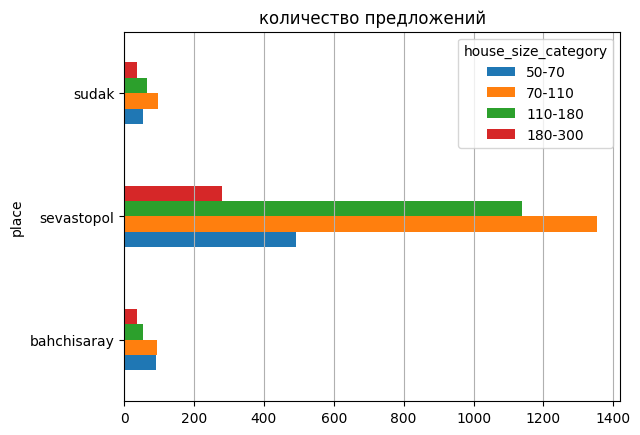

In [27]:
(
gdf
.query('house_size_category in @sizes')
.drop_duplicates(['url'])
.groupby(['house_size_category','place'],observed=True)['url'].count()
.reset_index()
.pivot(index='place', columns='house_size_category', values='url')
.plot.barh(title='количество предложений') #,log=True)
.grid(axis='x')    
)

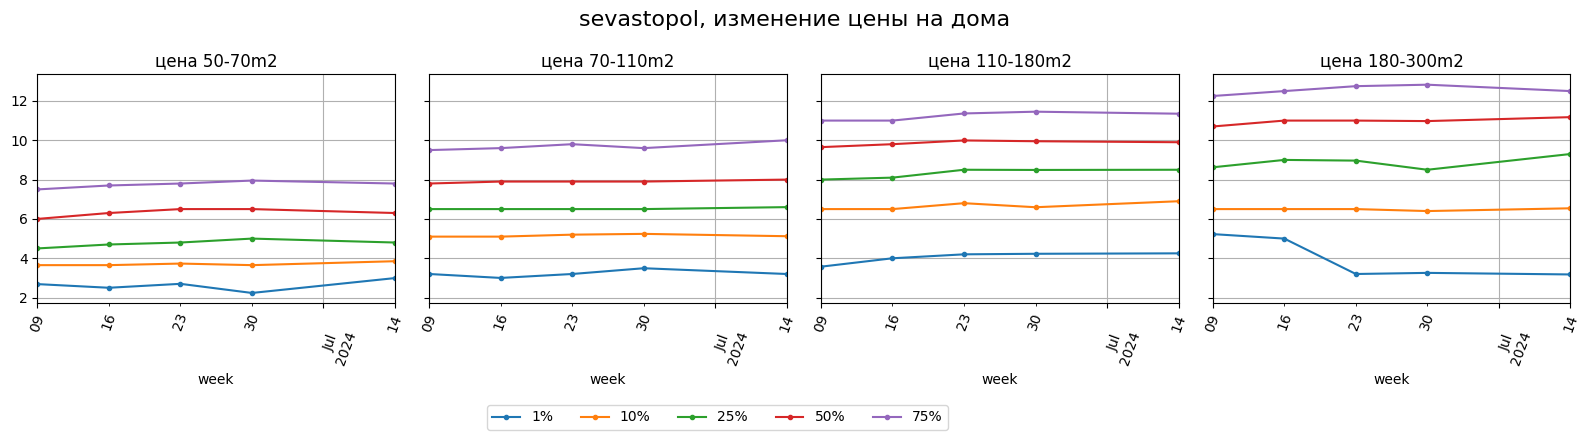

In [28]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

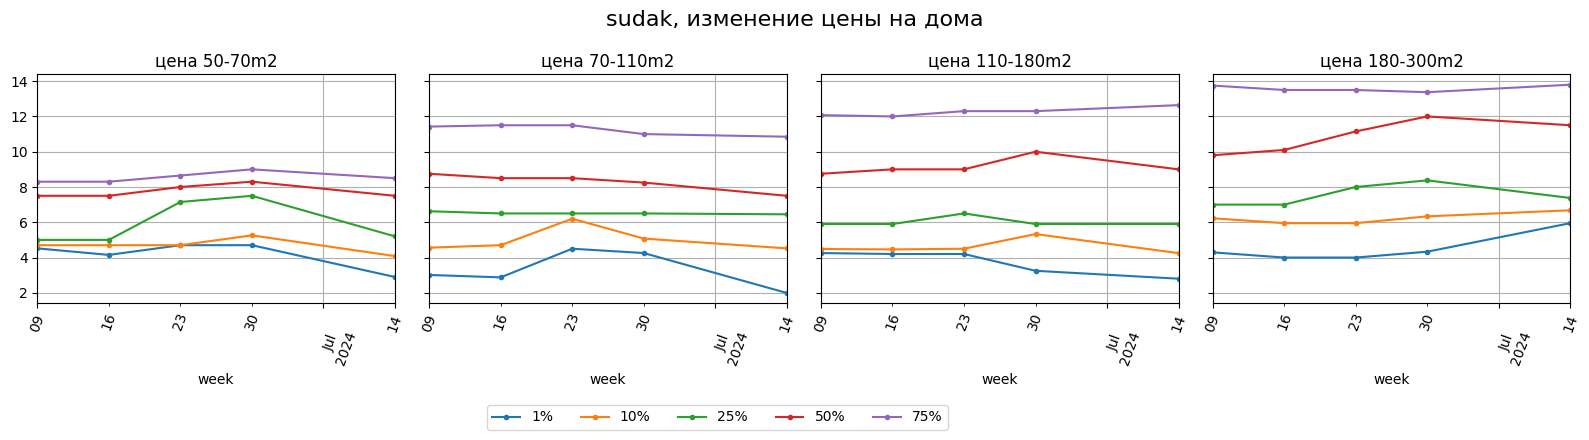

In [29]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на дома', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [30]:
# dt_now = pd.to_datetime('2024-06-17').date()
dt_now = gdf['dt'].max()

display(len(gdf))
gdf_last = gdf[ gdf['dt'] == dt_now ]
display(len(gdf_last))

24082

2612

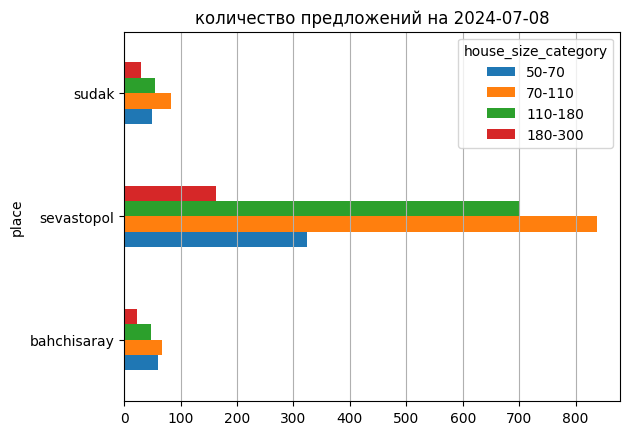

In [31]:
(
gdf_last
.query('house_size_category in @sizes')
.drop_duplicates(['url'])
.groupby(['house_size_category','place'],observed=True)['url'].count()
.reset_index()
.pivot(index='place', columns='house_size_category', values='url')
# .plot.barh(title='количество предложений') #,log=True)
.plot.barh(title='количество предложений на '+ str( dt_now ))
.grid(axis='x')    
)

In [32]:
(
    gdf_last
    .groupby(['place','house_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean  std   min    1%    5%   10%  \
place       house_size_category                                             
bahchisaray 30-50                27.00  4.00 1.56  2.00  2.05  2.21  2.27   
            50-70                60.00  5.67 2.13  1.90  2.02  2.78  3.00   
            70-110               67.00  7.04 2.93  2.50  2.50  3.36  3.79   
            110-180              48.00  8.36 3.21  2.70  2.72  3.47  3.70   
            180-300              23.00  9.60 3.04  4.00  4.00  4.24  6.42   
            300+                  6.00 12.17 1.94 10.00 10.00 10.00 10.00   
sevastopol  30-50               102.00  5.68 2.18  1.95  2.00  3.30  3.50   
            50-70               324.00  6.45 2.13  1.90  2.99  3.60  3.85   
            70-110              837.00  8.24 2.41  1.74  3.20  4.25  5.12   
            110-180             701.00  9.80 2.27  2.30  4.25  5.95  6.90   
            180-300             162.00 10.74 2.66  3.00  3.18  6.00  6.54   
            300+                 11.00 10.30 2.95  3.80  4.12  5.40  7.00   
sudak       30-50                20.00  7.58 3.79  3.00  3.00  3.00  3.36   
            50-70                49.00  7.30 2.46  2.80  2.90  3.20  4.08   
            70-110               83.00  8.11 2.85  1.50  1.99  3.72  4.52   
            110-180              55.00  9.24 3.83  2.80  2.80  3.15  4.25   
            180-300              30.00 10.88 3.16  5.95  5.95  6.20  6.68   
            300+                  7.00  9.41 2.65  6.50  6.54  6.71  6.92   

                                  25%   50%   75%   90%   95%   max  
place       house_size_category                                      
bahchisaray 30-50                2.65  3.80  4.97  5.38  5.96  9.00  
            50-70                4.07  5.50  7.08  8.32  9.95 10.00  
            70-110               5.40  6.50  8.00 12.20 13.70 14.50  
            110-180              6.17  8.50 11.00 12.00 13.25 14.55  
            180-300              7.40  9.95 12.25 13.76 14.27 14.30  
            300+                10.50 12.50 13.00 14.00 14.49 14.99  
sevastopol  30-50                4.22  5.58  6.50  7.86  9.49 14.30  
            50-70                4.80  6.30  7.80  9.13 10.00 14.00  
            70-110               6.60  8.00 10.00 11.50 12.00 14.90  
            110-180              8.50  9.90 11.35 12.50 13.70 15.00  
            180-300              9.30 11.18 12.50 13.50 14.75 14.95  
            300+                 8.80 11.60 12.50 13.00 13.00 13.00  
sudak       30-50                4.37  7.25 10.00 13.41 13.53 14.00  
            50-70                5.20  7.50  8.50 10.50 11.22 13.50  
            70-110               6.45  7.50 10.85 12.24 12.49 12.90  
            110-180              5.90  9.00 12.64 13.96 14.90 14.99  
            180-300              7.38 11.50 13.80 14.95 14.97 14.99  
            300+                 7.20  9.00 11.25 12.30 12.90 13.50

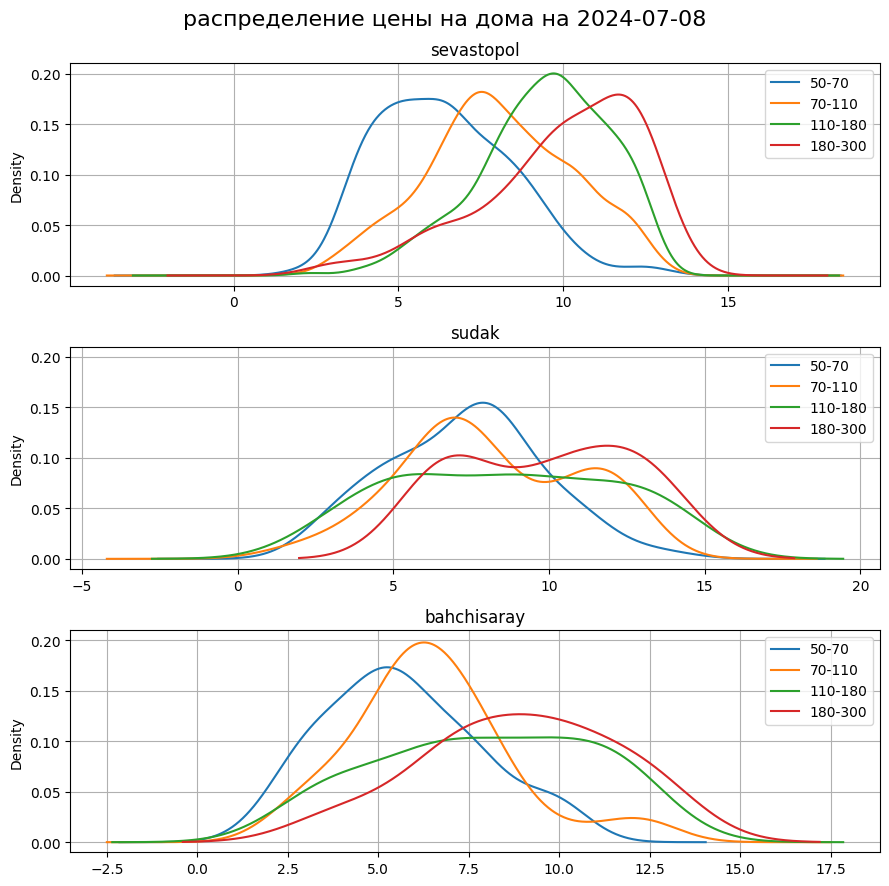

In [33]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
        .groupby(['house_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
fig.tight_layout()

In [34]:
# (
# gdf_last
# .query(f' (place=="{p}") & (priceM<{q_95[p]}) & (house_size_category in {sizes})')
# .groupby(['house_size_category'],observed=True)
# ['priceM'].plot.kde()
# )

# цены на карте

In [35]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [36]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [37]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [38]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [39]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [40]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## Судак

In [41]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

# frame_sudak.explore()

In [42]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)
grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

# районы Севастополя

In [43]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [44]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [45]:
frames.explore('area_name', legend=True)

In [46]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
#'Севастополь, Малахов курган',
'Севастополь, кр.горка (старый)',
'Севастополь, кр.горка (новый)',
'Севастополь, Благополучный',
]

In [47]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

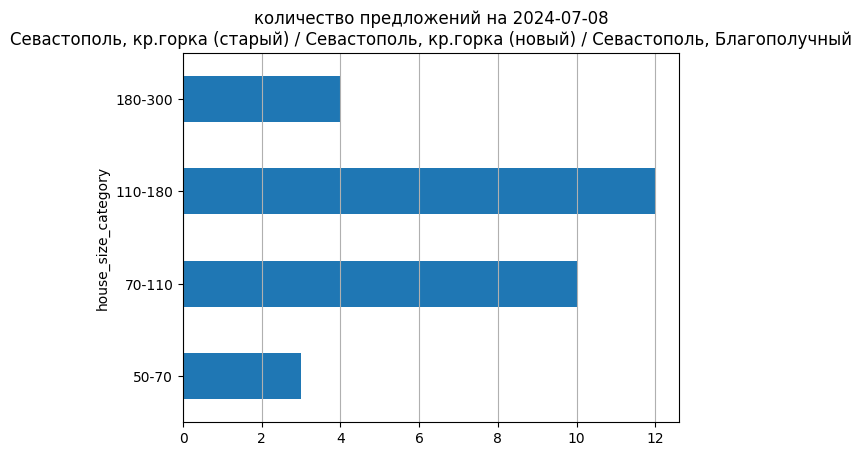

In [48]:
(
    gdf_last_local
    .drop_duplicates('url')
    .query('house_size_category in @sizes')
    .groupby(['house_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str(dt_now) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

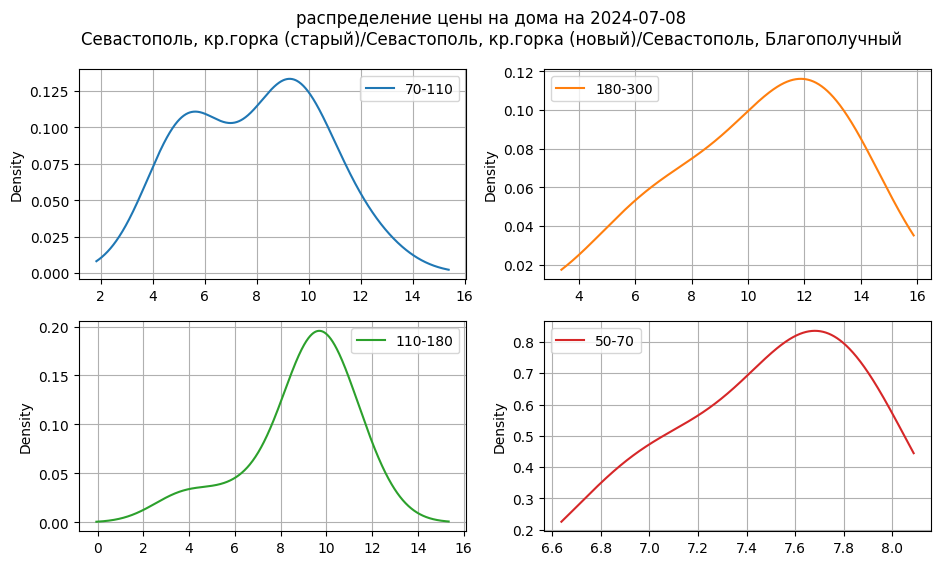

In [49]:
q_95 = gdf_last_local['priceM'].quantile(.95)

# fig, ax = plt.subplots() #figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})')
    .query('house_size_category in @sizes')
    #.groupby(['house_size_category'],observed=True)
    .pivot(columns='house_size_category',values='priceM')
    #['priceM']
    #.count()
    .plot.kde(
        legend=True,
        #ax=ax,
        # title='/'.join(area_name), 
        title=f'распределение цены на дома на '+ str( dt_now )+ '\n'+'/'.join(area_name), 
        grid=True,
        subplots=True,
        layout=(2,2),
        figsize=(11,6),
        sharex=False
    )   
)
#fig.suptitle(f'распределение цены на дома на '+ str( dt_now ), fontsize=16)
#fig.tight_layout()

----

In [50]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [51]:
stat = (
        gdf_local
        # .groupby(['house_size_category','month'],observed=True)
        .groupby(['house_size_category','week'],observed=True)
        ['priceM'].describe(percentiles=percentiles)
        #.dropna()
    )
display( stat )

count  mean  std  min   1%   5%  \
house_size_category week                                                     
30-50               2024-06-03/2024-06-09   3.00  5.90 0.09 5.85 5.85 5.85   
                    2024-06-10/2024-06-16  12.00  5.83 0.14 5.70 5.70 5.70   
                    2024-06-17/2024-06-23   7.00  5.83 0.16 5.70 5.70 5.70   
                    2024-06-24/2024-06-30   3.00  5.80 0.17 5.70 5.70 5.70   
                    2024-07-08/2024-07-14   3.00  5.82 0.16 5.70 5.70 5.71   
50-70               2024-06-03/2024-06-09   3.00  7.27 0.79 6.35 6.38 6.49   
                    2024-06-10/2024-06-16  11.00  7.39 1.35 6.35 6.35 6.35   
                    2024-06-17/2024-06-23  13.00  7.03 0.63 6.35 6.35 6.35   
                    2024-06-24/2024-06-30   4.00  7.20 0.66 6.35 6.37 6.45   
                    2024-07-08/2024-07-14   3.00  7.48 0.42 7.00 7.01 7.07   
70-110              2024-06-03/2024-06-09  13.00  7.60 2.57 5.22 5.23 5.24   
                    2024-06-10/2024-06-16  47.00  7.45 2.44 5.22 5.22 5.22   
                    2024-06-17/2024-06-23  34.00  7.50 2.39 5.22 5.22 5.22   
                    2024-06-24/2024-06-30  14.00  7.55 2.51 5.22 5.23 5.24   
                    2024-07-08/2024-07-14  10.00  7.95 2.45 5.22 5.22 5.22   
110-180             2024-06-03/2024-06-09   9.00 10.22 2.81 6.50 6.50 6.50   
                    2024-06-10/2024-06-16  45.00 10.33 2.62 6.50 6.50 6.50   
                    2024-06-17/2024-06-23  27.00  9.87 2.89 4.25 4.83 6.50   
                    2024-06-24/2024-06-30   9.00  8.92 2.92 4.25 4.43 5.15   
                    2024-07-08/2024-07-14  12.00  9.81 2.91 3.80 4.10 5.29   
180-300             2024-06-03/2024-06-09   2.00  8.25 2.47 6.50 6.54 6.67   
                    2024-06-10/2024-06-16  12.00  9.75 2.67 6.50 6.50 6.50   
                    2024-06-17/2024-06-23   9.00 10.36 3.03 6.50 6.50 6.50   
                    2024-06-24/2024-06-30   2.00  9.62 4.42 6.50 6.56 6.81   
                    2024-07-08/2024-07-14   4.00 10.50 2.97 6.50 6.61 7.03   

                                           10%  25%   50%   75%   90%   95%  \
house_size_category week                                                      
30-50               2024-06-03/2024-06-09 5.85 5.85  5.85  5.92  5.97  5.99   
                    2024-06-10/2024-06-16 5.70 5.70  5.78  6.00  6.00  6.00   
                    2024-06-17/2024-06-23 5.70 5.70  5.70  6.00  6.00  6.00   
                    2024-06-24/2024-06-30 5.70 5.70  5.70  5.85  5.94  5.97   
                    2024-07-08/2024-07-14 5.71 5.72  5.75  5.88  5.95  5.97   
50-70               2024-06-03/2024-06-09 6.62 7.04  7.72  7.72  7.72  7.72   
                    2024-06-10/2024-06-16 6.35 6.35  7.00  7.72  7.72  9.36   
                    2024-06-17/2024-06-23 6.35 6.35  7.00  7.72  7.72  7.72   
                    2024-06-24/2024-06-30 6.54 6.84  7.36  7.72  7.72  7.72   
                    2024-07-08/2024-07-14 7.14 7.36  7.72  7.72  7.72  7.72   
70-110              2024-06-03/2024-06-09 5.28 5.50  6.50  8.70  9.60 11.36   
                    2024-06-10/2024-06-16 5.25 5.45  6.50  9.15  9.60 12.68   
                    2024-06-17/2024-06-23 5.25 5.43  6.50  9.38  9.60 11.14   
                    2024-06-24/2024-06-30 5.29 5.50  6.50  8.65  9.88 11.40   
                    2024-07-08/2024-07-14 5.22 5.40  8.75  9.60  9.84 10.92   
110-180             2024-06-03/2024-06-09 6.50 9.60 10.00 11.30 13.80 14.39   
                    2024-06-10/2024-06-16 6.50 8.90 10.00 12.25 14.39 14.98   
                    2024-06-17/2024-06-23 6.50 7.40 10.00 12.25 13.50 14.54   
                    2024-06-24/2024-06-30 6.05 6.50  9.00 10.00 12.50 13.00   
                    2024-07-08/2024-07-14 6.74 8.97  9.59 11.04 13.30 14.17   
180-300             2024-06-03/2024-06-09 6.85 7.38  8.25  9.12  9.65  9.82   
                    2024-06-10/2024-06-16 6.50 6.50 10.00 12.75 12.75 12.75   
                    2024-06-17/2024-06-2

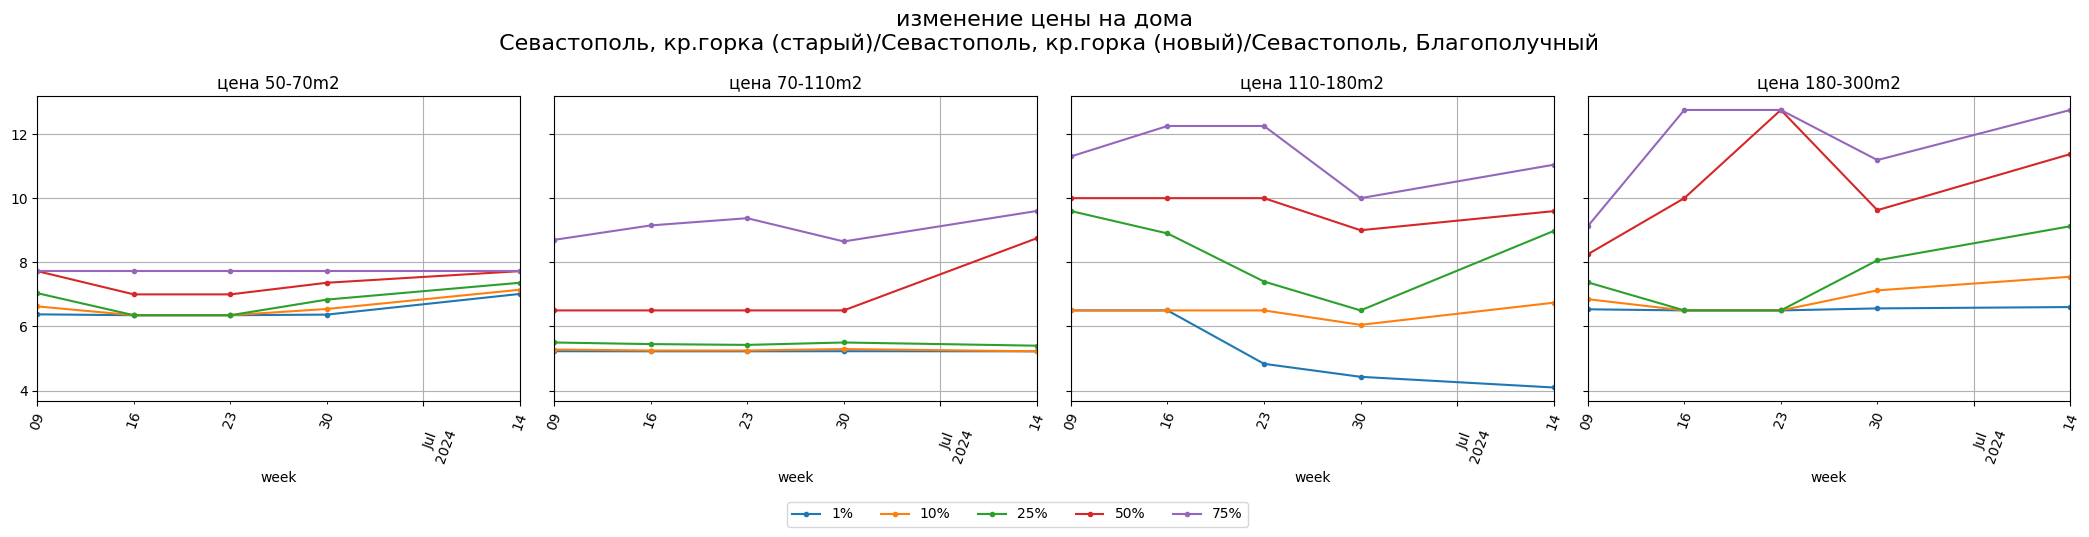

In [52]:
fig, ax = plt.subplots(1,len(sizes),figsize=(21,5), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на дома\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [ ]:
# df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
# df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [ ]:
# df.info()

In [ ]:
# df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
# df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

# df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
# df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
# df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 

# df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [ ]:
# df.loc[ df['address']=='квартал Старый Город', 'place'] = 'turkie'
# df.loc[ df['address'].str.lower().str.match('анталья'), 'place' ] = 'turkie' 

# df.loc[ df['address'].str.lower().str.match(r'.*бахчисарай.*'), 'place' ] = 'bahchisaray'
# df.loc[ df['address'].str.lower().str.match(r'.*севастополь,.*'), 'place' ] = 'sevastopol'

# df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*алушта.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*гурзуф.*'), 'place' ] = 'gurzuf'

# df.loc[ df['address'].str.lower().str.match(r'.*с.лучистое.*'), 'place' ] = 'alushta'
# df.loc[ df['address'].str.lower().str.match(r'.*снт солнечная долина.*'), 'place' ] = 'sudak'
# df.loc[ df['address'].str.lower().str.match(r'.*пгт.новоозёрное.*'), 'place' ] = 'evpatoria'

# df.loc[ df['address'].str.lower().str.match(r'.*с.мирное.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*тсн аэрофлот.*'), 'place' ] = 'simferopol'
# df.loc[ df['address'].str.lower().str.match(r'.*симферопольский район.*'), 'place' ] = 'simferopol'

# df.loc[ df['address'].str.lower().str.match(r'.*семисот.*'), 'place' ] = 'kerch'

# df.loc[ df['address'].str.lower().str.match(r'.*ялта.*') , 'place' ] = 'yalta'
# df.loc[ df['address'].str.lower().str.match(r'.*феодосия.*') , 'place' ] = 'feodosia'
# df.loc[ df['address'].str.lower().str.match(r'.*окуневка.*') , 'place' ] = 'tarkhankut'
# df.loc[ df['address'].str.lower().str.match(r'.*заветное.*') , 'place' ] = 'kerch'
# df.loc[ df['address'].str.lower().str.match(r'.*евпатория.*') , 'place' ] = 'evpatoria'